# TP2
### Étudiant
    1. Félix Moreau 1846157
    2. Axel Massucci Templier
    3. Hermann Noubissie Noussa
    4. Pier-Olivier Côté


In [1]:
import yfinance as yf 
from pandas_datareader import data, wb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
import math as mt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
#from Data_TP2_V2 import BBANDS, STOK, MACD, RSI, MFI
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import talib

In [2]:
start_sp = datetime.datetime(2018,3,31)
end_sp = datetime.datetime(2020, 12,31)

# Use Vanguard ETF
# SP500 Index + 11 Industry

BLack_ETF=['IVV','IWF','IJH','IJR','IWM','IVW']


#BLack_ETF=['IVV','IWF','IJH','IJR','IWM','IWD','ITOT','IVW','IWB','IWR','DVY',
#           'IVE','IWP','IWS','IWV','IUSG','IWO','IWN','IBB','IJK','IUSV',
#           'OEF','IJS','IJJ','IYW','IHI','IJT','ITA','IGV','IYH','SOXX','EWC',
#           'IGM','IYF','JKE','SUSA','IDU','IYY','IYG','JKD','IYC','IYJ','JKG',
#           'IWC','IYK','JKF','JKH','IYT','JKI','IYZ','IGE','IYE','JKL','IYM',
#           'JKJ','JKK','IGN']

# To access data for SP500
#SP500_dat=Data['IVW']

# To access the adjusted close price, use
#Data['IVW']['Adj Close']

# Graph data
#Data['IVW']['Adj Close'].plot(grid=True)

# To get Information about a ticker
#SP500_detail = yf.Ticker("IVW")

# Show stock info
#SP500_detail.info

In [3]:
def get_Data_bin(ticker):
    Data = yf.download(ticker, start=start_sp, end=end_sp,group_by="ticker")
    rendement = pd.DataFrame(Data['Adj Close'].T.pct_change())
    rendement_bin = pd.DataFrame(np.where(rendement['Adj Close'].shift(-1) > rendement['Adj Close'], 1, 0),
                                index = rendement.index)
    return rendement_bin, Data

In [68]:
def data_preprocessing(ticker, Data):
    #RSI
    dataset = pd.DataFrame(index = Data.index)
    dataset['RSI'] = talib.RSI(Data['Close'], timeperiod = 14)
    
    #MFI
    dataset['MFI'] = talib.MFI(Data['High'], Data['Low'], Data['Close'], Data['Volume'], timeperiod=14)
    
    #BBANDS
    dataset['BBANDS_UP'], dataset['BBANDS_MID'], dataset['BBANDS_DOWN'] = talib.BBANDS(
        Data['Close'],timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
                                                                                       
    #STOCHASTIC                                                              
    dataset['STO_k'], dataset['STO_d'] = talib.STOCH(Data['High'], Data['Low'], Data['Close'],
                         fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    
    #MACD
    macd, dataset['MACD'], macdhist = talib.MACD(Data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    
    #OBV
    dataset['OBV'] = talib.OBV(Data['Close'], Data['Volume'])
    
    #ADX
    dataset['ADX'] = talib.ADX(Data['High'], Data['Low'], Data['Close'], timeperiod=14)
    
    #MA
    dataset['MA'] = talib.MA(Data['Close'], timeperiod=30, matype=0)
    
    #SMA
    dataset['SMA'] = talib.SMA(Data['Close'], timeperiod=30)
    
    return dataset

In [69]:
X=pd.DataFrame()
Y=pd.DataFrame()
for etf in BLack_ETF:
    Y_bin, Data = get_Data_bin(etf)
    dataset_ini = data_preprocessing(etf, Data)
    X = pd.concat([X,dataset_ini])
    Y = pd.concat([Y,Y_bin])
X['Y'] = Y
X = X.dropna()
Y = X['Y']
X = X.drop(columns = 'Y')
X

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,RSI,MFI,BBANDS_UP,BBANDS_MID,BBANDS_DOWN,STO_k,STO_d,MACD,OBV,ADX,MA,SMA
Date,,,,,,,,,,,,
2018-05-17,64.443586,50.274933,275.382031,274.016003,272.649976,52.815847,65.688664,1.273146,26826300.0,11.276939,268.754669,268.754669
2018-05-18,62.399670,52.218954,275.166444,273.764001,272.361559,45.161233,54.556595,1.417487,24563700.0,11.317720,269.142669,269.142669
2018-05-21,65.878569,58.543490,275.492180,273.841998,272.191816,54.824799,50.933960,1.555606,26360000.0,11.925561,269.559668,269.559668
2018-05-22,63.536217,60.266166,275.495246,274.173999,272.852752,54.998538,51.661523,1.667234,24440800.0,12.351078,269.809668,269.809668
2018-05-23,64.950832,61.961921,275.971141,274.403998,272.836855,68.452207,59.425181,1.765051,26719000.0,12.239083,270.134002,270.134002
2018-05-24,63.256713,54.078445,276.064924,274.577997,273.091069,60.483868,61.311537,1.837082,23526600.0,12.030448,270.366001,270.366001
2018-05-25,60.633862,46.643876,275.683318,274.732001,273.780684,56.491822,61.809299,1.872705,20199400.0,11.836715,270.599668,270.599668
2018-05-29,51.521015,45.500491,276.934676,273.876001,270.817326,38.952199,51.975963,1.830710,16022800.0,11.814353,270.657668,270.657668
2018-05-30,59.333148,46.351023,276.963742,273.891998,270.820255,48.074722,47.839581,1.795850,19927500.0,11.037960,270.740334,270.740334


In [70]:
def calculate_aic(n, mse, num_params):
    aic = n * mt.log(mse) + 2 * num_params
    return aic

In [71]:
def calculModelLogit(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 0)
    ModeleLogit = LogisticRegression()
    TrainFit = ModeleLogit.fit(trainX, trainY)
    TrainScores = ModeleLogit.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleLogit.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleLogit.predict(testX)
    proba = ModeleLogit.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, ModeleLogit.coef_, testY, ModeleLogit, proba

In [72]:
def getROC(yTest, prediction, proba):
    fpr, tpr, thres = roc_curve(yTest, proba)
    ac = roc_auc_score(yTest, prediction)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % ac)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [73]:
def getMC(yTest, prediction):
    matrice = confusion_matrix(yTest, prediction)
    print(matrice) 

In [74]:
def verificationCoef(coef, data):
    dataAmeliorer = data
    for i in range(0,len(coef)):
        if coef[i] < -0.5:
            sigle = data.columns[i]
#print(sigle)
            if sigle in dataAmeliorer.columns:
                dataAmeliorer = dataAmeliorer.drop(sigle, axis="columns")
    return dataAmeliorer

In [75]:
predictions, TrainScores, TestsScorelogit, aic, coefficientModel, testY, model, proba = calculModelLogit(X, Y)

Train score= 0.5072247135027405
Test score= 0.5249709639953543
AIC score : -616.910618959424


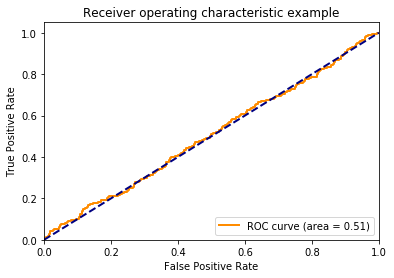

In [76]:
getROC(testY, predictions, proba)

In [77]:
getMC(testY, predictions)

[[418  29]
 [380  34]]


In [78]:
coefficientModel

array([[-1.51616410e-15, -1.11224807e-15, -2.01123333e-15,
        -1.98548999e-15, -1.95974666e-15, -2.55234198e-15,
        -1.44667973e-15,  2.42083505e-17, -3.14683109e-10,
        -2.71593796e-16, -1.96451924e-15, -1.96451924e-15]])

In [79]:
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
rfe = RFE(model, 20)
rfe = rfe.fit(X, Y)
print(rfe.support_)
print(rfe.ranking_)
rapport = rfe.support_

nouvelleDB=X
## On veut visualiser les variables qui ne sont pas sélectionnées
for i in range(0,len(rapport)):
    if rapport[i]==False :
        sigle = Signal_tot
        print("Le paramètre:",feature_list[i], "n'est pas selectionné")
        nouvelleDB = nouvelleDB.drop(sigle, axis="columns")

[ True  True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1]


# Arbre de decision

In [80]:
def calculModelArbreDecision(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 0)
    ModeleArbre = DecisionTreeClassifier()
    
    TrainFit = ModeleArbre.fit(trainX, trainY)
    
    TrainScores = ModeleArbre.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleArbre.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleArbre.predict(testX)
    
    proba = ModeleArbre.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, testY, testX, proba

In [81]:
predictions, TrainScores, TestsScoretree, aic, testY, testX, prob = calculModelArbreDecision(X, Y)

Train score= 1.0
Test score= 0.5853658536585366
AIC score : -733.988860200007


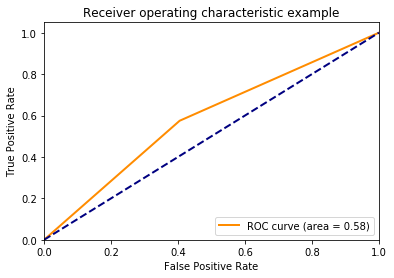

In [82]:
getROC(testY, predictions, prob)

In [83]:
getMC(testY, predictions)

[[266 181]
 [176 238]]


In [84]:
nouvellePredictions, nouveauTrainScores, nouveauTestsScore, nouveauAIC, nouveautestY, nouveautestX, prob = calculModelArbreDecision(nouvelleDB, Y)

Train score= 1.0
Test score= 0.5830429732868757
AIC score : -729.1787918238681


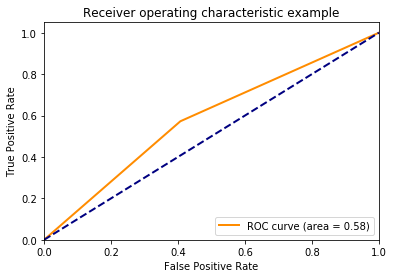

In [85]:
getROC(nouveautestY, nouvellePredictions, prob)

In [86]:
getMC(nouveautestY, nouvellePredictions)

[[265 182]
 [177 237]]


# Random Forest

In [87]:
def calculModelRandomForest(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    ModeleRF = RandomForestClassifier()
    
    TrainFit = ModeleRF.fit(trainX, trainY)
    
    TrainScores = ModeleRF.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleRF.score(testX, testY)
    print('Test score=',TestsScore)
    
    proba = ModeleRF.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    variableImportante = ModeleRF.feature_importances_
    return predictions, TrainScores, TestsScore, aic, testY, variableImportante, proba

In [88]:
predictions, TrainScores, TestsScoreforest, AIC, testY, variableImportante, prob = calculModelRandomForest(X, Y)

Train score= 1.0
Test score= 0.586527293844367
AIC score : -561.8693967887577


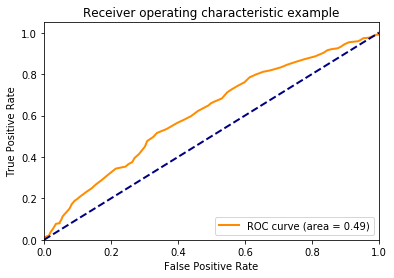

In [89]:
getROC(testY, predictions, prob)

In [90]:
getMC(testY, predictions)

[[227 221]
 [215 198]]


In [91]:
print(variableImportante)

[0.13426955 0.0901712  0.06070089 0.0568878  0.05823486 0.11672874
 0.11207418 0.09452819 0.08113617 0.08604136 0.0552454  0.05398165]


# Répétez l’exercices pour des méthodes plus flexibles mais opaques.

In [92]:
from sklearn.svm import SVC 
def calculModelSVM(X,Y,typ):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    ModeleSVM = SVC(kernel=typ)
    
    TrainFit = ModeleSVM.fit(trainX, trainY)
    
    TrainScores = ModeleSVM.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleSVM.score(testX, testY)
    print('Test score=',TestsScore)
    
    #proba = ModeleSVM.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, testY, proba

In [ ]:
predictions, TrainScores, TestsScorelin, aic, testY, prob = calculModelSVM(X,Y,'linear')

In [ ]:
getROC(nouveautestY, nouvellePredictions, prob)

In [ ]:
getMC(testY, predictions)

In [ ]:
predictions, TrainScores, TestsScoreradial, aic, testY, prob = calculModelSVM(X,Y,'rbf')

In [ ]:
getROC(nouveautestY, nouvellePredictions, prob)

In [ ]:
getMC(testY, predictions)

# Comparer une dernière fois, l’ensemble des modèles, sélectionnez-en un et expliquez votre choix.

In [ ]:
accuracy = pd.DataFrame([TestsScorelogit,TestsScoreforest,TestsScoretree, TestsScoreradial,TestsScorelin],
                       index = ['Logit','Forest','Tree','Radial','Linéaire'], columns = ['%Tests'])*100
accuracy

# Répétez l’exercice mais cette fois-ci pour chaque ETF pris individuellement.

Source :

https://github.com/mrjbq7/ta-lib

https://medium.com/@rbhatia46/using-svm-on-top-of-technical-indicators-to-predict-reliance-stock-prices-abb494d9f45f